In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Feature Analysis

In [317]:
qb = pd.read_csv("data/finalized_data/finalized_QB.csv", index_col=0)
de = pd.read_csv("data/finalized_data/finalized_DEF.csv", index_col=0)
rb = pd.read_csv("data/finalized_data/finalized_RB.csv", index_col=0)
te = pd.read_csv("data/finalized_data/finalized_TE.csv", index_col=0)
wr = pd.read_csv("data/finalized_data/finalized_WR.csv", index_col=0)


### VARIABLES 

#### According to Khang - Essential Variables for prediction!
- DEF: Ints, Fumbles, Fumbles Lost
- QB: TD Passes, Completion Percentage, Passer Rating
- RB: Rushing Attempts, Receptions, Yards Per Carry
- WR and TE: Yards per Reception, Yards Per Carry

#### Very important variables
- week (for time series)
- Outcome
- Score

#### Useless variables
- Season 
- Position (same as file name, except for FB and RB in RB)
- Game Date is probably irrelevant if we have the weeks?
- Also all Years are 2019
- All Games Played are 1
- All Years Played are nan

#### All
- week (1) #integer
- opponent ('PIT') #string
- team ('det') #string
- salary (4500) #integer
- name ('Gabriel, Taylor' or 'Minnesota') #string
- Player Id

#### ALL BUT DEF AND QB
- Longest Reception ('5T' '-8' '--') #string
- Longest Rushing Run ('--' '4T' '9') #string
- Receptions ('--' or '1') #string
- Yards per Reception ('--' '6.0') #string

#### All BUT DEF
- Year (2019) #integer
- Game Date ('09/08') #string
- Home or Away ('Away') #string
- Outcome ('W') #string
- Score ('59 to 10') #string -> x to y --> x - y
- Games Started (1 or 0) #integer
- Rushing Attempts ('7' or '--') #string
- Yards Per Carry ('10.7' or '--') #string
- Rushing TDs ('1' or '--') #string
- Rushing Yards ('32' or '--' ) #string
- Fumbles ('--' or '1') #string
- Fumbles Lost ('--' or '1') #string
- Age (21.) #float?
- Birth Place ('Gainesville , GA') #string
- Birthday ('1/7/1997') #string
- College ('Louisville') #string
- Current Status ('Injured reserve') #string
- Current Team ('Buffalo Bills') #string WHAT IS THE DIFFERENCE BETWEEN THIS AND team???
- Experience ('10th season') #string
- Height (inches) (71.) #float
- High School ('Grand Blanc HS') #string
- High School Location ('Powder Springs, GA' or 'GA') #string
- Number (nan or 17. ) #float
- Weight (lbs) (260.) #float

#### ONLY ON QB 
- Passes Completed ('17' or '--') #string
- Passes Attempted ('17' or '--') #string
- Completion Percentage ('57.7' or '--') #string
- Passing Yards ('308' or '--') #string
- Passing Yards Per Attempt ('9.1' or '--') #string
- TD Passes ('3' or '--') #string
- Ints ('2' or '--') #string
- Sacks ('3' or '--') #string
- Sacked Yards Lost ('17' or '--') #string
- Passer Rating (71.9) #float

### Next Steps

1. Do analysis for the rest of features (CHECK)
2. One-hot-encode the strings and convert all ints to floats
3. Create one feature vector per instance
4. Separate the time variable, and labels
5. Start experimenting with regressors

In [318]:
all_cols = list(qb.columns) + list(rb.columns) + list(wr.columns) + list(te.columns)
all_cols = set(all_cols)
def_cols = list(de.columns)
len(all_cols), def_cols

(52, ['name', 'team', 'opponent', 'points', 'salary', 'week'])

## Data Engineering

In [319]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [320]:
### Remove columns
# to_remove = ["Season", "Position", "Game Date", "Year", "Games Played", "Years Played", "Player Id", "name"]
to_remove = ["Season", "Position", "Game Date", "Year", "Games Played", "Years Played"]
targets = [qb, wr, te, rb]

for target in targets:
    target.drop(to_remove, axis=1, inplace=True)

In [321]:
all_numerical_cols = ["week", "salary"]

not_def_numerical_cols = ["Games Started", "Rushing Attempts", "Yards Per Carry", "Rushing TDs", 
                          "Rushing Yards", "Fumbles", "Fumbles Lost", "Age", "Height (inches)", 
                          "Weight (lbs)", "Number"]

not_def_qb_numerical_cols = ["Receptions", "Yards Per Reception"]

only_qb = ["Passes Completed", "Passes Attempted", "Completion Percentage", "Passing Yards", "Sacked Yards Lost",
           "Passing Yards Per Attempt", "TD Passes", "Ints", "Sacks", "Passer Rating"]

In [322]:
# Convert all numerical values to floats
for target in [qb, wr, te, rb, de]:
    for col in all_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")

for target in targets:
    for col in not_def_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")

for target in [wr, te, rb]:
    for col in not_def_qb_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")
        
for col in only_qb:
    qb[col] = qb[col].replace("--", "0").astype("float64")

In [323]:
qb.columns

Index(['Player Id', 'name', 'week', 'Home or Away', 'opponent', 'Outcome',
       'Score', 'Games Started', 'Passes Completed', 'Passes Attempted',
       'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt',
       'TD Passes', 'Ints', 'Sacks', 'Sacked Yards Lost', 'Passer Rating',
       'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs',
       'Fumbles', 'Fumbles Lost', 'Unnamed: 0.1', 'team', 'points', 'salary',
       'Age', 'Birth Place', 'Birthday', 'College', 'Current Status',
       'Current Team', 'Experience', 'Height (inches)', 'High School',
       'High School Location', 'Number', 'Weight (lbs)'],
      dtype='object')

In [110]:
### Transform data
final_dfs = []

def transform(target):
    
    # Retrieve columns w/ categorical data
    cat = target.select_dtypes(include=['object']).copy()
    
    #Return df with onehot encoding applied to the columns which are categorical
    one_hot = pd.get_dummies(target, columns=cat.columns)
    one_hot = one_hot.replace(np.nan, 0.0)
    
    return one_hot

qb = transform(qb)
wr = transform(wr)
te = transform(te)
rb = transform(rb)

In [15]:
# Turn into X and Y
qb_X = qb.drop("points", axis=1).values
qb_y = qb["points"].values

In [16]:
qb_X

array([[ 1.,  1., 17., ...,  0.,  0.,  0.],
       [ 5.,  1., 19., ...,  0.,  0.,  0.],
       [ 7.,  1.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  1., 18., ...,  0.,  0.,  0.],
       [ 5.,  1., 28., ...,  0.,  0.,  0.],
       [ 7.,  1., 31., ...,  0.,  0.,  0.]])

In [12]:
len(qb_X)

103

In [13]:
# Scale/normalize values
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(qb_X)
# Apply transform to both the training set and the test set.
qb_X = scaler.transform(qb_X)

In [14]:
len(qb_X)

103

In [15]:
# Perform Grid Search on PCA
pca = PCA(n_components=0.95)
pca.fit(qb_X)
trans_qb_X = pca.transform(qb_X)

# param_grid = {
#     'n_components': [20, 35, 50, 65, 0.95]
# }
# search = GridSearchCV(pca, param_grid, n_jobs=-1)
# search.fit(qb_X, qb_y)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)


In [16]:
len(trans_qb_X[0])

72

## Regression

In [381]:
# Apply simple Ridge Regression for testing purposes
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [382]:
X_train, X_test, y_train, y_test=train_test_split(qb_X, qb_y, test_size=0.2,random_state=69420)

In [383]:
ridge = Ridge()
param_grid = {
    'alpha': [0.01, 0.1, 0.2, 1, 10, 100]
}
search = GridSearchCV(ridge, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/dafirebanks/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter (CV score=0.611):
{'alpha': 10}


In [386]:
ridge_opt = Ridge(alpha=10, random_state=69420)
ridge_opt.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=69420, solver='auto', tol=0.001)

In [387]:
preds = ridge_opt.predict(X_test)

In [395]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [406]:
max(y_test), min(y_test)

(28.9, 1.16)

In [393]:
mean_absolute_error(y_test, preds)

4.002270756503693

In [394]:
mean_squared_error(y_test, preds)

25.827383540169226

In [395]:
r2_score(y_test, preds)

0.5532005272426592

In [401]:
np.sqrt(mean_squared_error(y_test, preds))

5.082064889409542

In [405]:
len(X_test), len(y_test), len(preds)

(21, 21, 21)

In [407]:
y_test, preds

(array([17.52, 28.9 , 24.66,  9.3 , 16.72,  1.16,  9.08,  8.98, 15.44,
        20.56, 24.92, 28.18,  3.58, 16.78, 21.54, 20.44, 14.44, 13.46,
        24.34, 12.92,  7.86]),
 array([18.9703144 , 21.49256999, 19.0090774 , 11.59092028, 16.48571005,
         9.66636725, 11.75678144, 11.09221383, 13.90925573, 23.38854914,
        17.32970451, 18.61086023,  4.07068359, 17.5215175 , 23.05563577,
        15.27304844, 20.9016149 , 17.46097512, 13.7700557 , 11.51462349,
         9.70701819]))

## Time Series Regression

In [44]:
# Source: http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

0. Remove all other features, leaving only week and score per player

In [387]:
# Remove features
time_qb = qb[['week', 'points', 'Player Id']]

# Sort by week and ID
time_qb = time_qb.sort_values(['week', 'Player Id'])
time_qb.head()

,week,points,Player Id
93,1.0,12.92,aaronrodgers/2506363
22,1.0,20.72,andydalton/2495143
67,1.0,27.20,casekeenum/2532888
61,1.0,-0.82,danieljones/2562299
30,1.0,14.84,elimanning/2505996


1. Some feature engineering on scores

In [388]:
time_qb2 = time_qb.copy()
time_qb2['Last_Week_Points'] = time_qb2.groupby(['Player Id'])['points'].shift()
time_qb2['Last_Week_Diff'] = time_qb2.groupby(['Player Id'])['Last_Week_Points'].diff()
time_qb2 = time_qb2.dropna()
time_qb2.head()

,week,points,Player Id,Last_Week_Points,Last_Week_Diff
24,4.0,4.64,andydalton/2495143,18.06,-2.66
17,5.0,21.16,gardnerminshew/2562796,16.72,0.60
86,5.0,18.90,jaredgoff/2555334,16.16,5.72
92,5.0,18.46,joshallen/2560955,22.22,4.26
8,5.0,32.90,mattryan/310,23.46,2.90


In [389]:
time_qb['week'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8.])

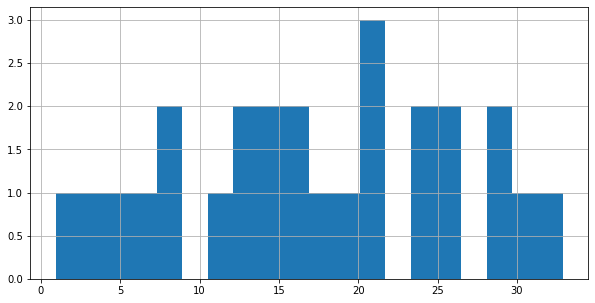

In [59]:
time_qb2['points'].hist(bins=20, figsize=(10,5))

In [390]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [391]:
# Try changing player id stuff?
time_qb['Player Id'] = time_qb['Player Id'].str.extract('(\d+)', expand=False).astype(int)

In [396]:
# Baseline model? We should look into this later
mean_error = []
for week in range(4, 9):
    train = time_qb2[time_qb2['week'] < week]
    val = time_qb2[time_qb2['week'] == week]
    
    p = val['Last_Week_Points'].values
    
    error = rmsle(val['points'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 4 - Error 13.42000
Week 5 - Error 10.38577
Week 6 - Error 14.46374
Week 7 - Error 10.38668
Week 8 - Error 9.58663
Mean Error = 11.64856


In [397]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [404]:
# Try Random Forests?
mean_error = []
mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=69420)
for week in range(2, 8):
    train = time_qb[time_qb['week'] < week]
    val = time_qb[time_qb['week'] == week]
    
    xtr, xts = train.drop(['points'], axis=1), val.drop(['points'], axis=1)
    ytr, yts = train['points'].values, val['points'].values

    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 2 - Error 10.56873
Week 3 - Error 7.87561
Week 4 - Error 9.84751
Week 5 - Error 11.80581
Week 6 - Error 10.64140
Week 7 - Error 9.19862
Mean Error = 9.98961


In [405]:
week = 8
train = time_qb[time_qb['week'] < week]
val = time_qb[time_qb['week'] == week]

xtr, xts = train.drop(['points'], axis=1), val.drop(['points'], axis=1)
ytr, yts = train['points'].values, val['points'].values

mdl.fit(xtr, ytr)

p = mdl.predict(xts)

error = rmsle(yts, p)
print('Week %d - Error %.5f' % (week, error))
# mean_error.append(error)
# print('Mean Error = %.5f' % np.mean(mean_error))

Week 8 - Error 11.54118


In [406]:
## time_qb3 = time_qb.copy()
time_qb3['Last_Week_Points'] = time_qb3.groupby(['Player Id'])['points'].shift()
time_qb3['Last_Week_Diff'] = time_qb3.groupby(['Player Id'])['Last_Week_Points'].diff()
time_qb3['Last-1_Week_Points'] = time_qb3.groupby(['Player Id'])['points'].shift(2)
time_qb3['Last-1_Week_Diff'] = time_qb3.groupby(['Player Id'])['Last-1_Week_Points'].diff()
time_qb3 = time_qb3.dropna()
time_qb3.head()

NameError: name 'time_qb3' is not defined

In [103]:
# Try Random Forests?
mean_error = []
for week in range(7, 9):
    train = time_qb3[time_qb3['week'] < week]
    val = time_qb3[time_qb3['week'] == week]
    
    xtr, xts = train.drop(['points'], axis=1), val.drop(['points'], axis=1)
    ytr, yts = train['points'].values, val['points'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=69420)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 7 - Error 0.26306
Week 8 - Error 0.84139
Mean Error = 0.55223


## Vector Auto Regression

In [110]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [19]:
import matplotlib.pyplot as plt

In [45]:
wr['Player Id'].unique()

array(['t.y.hilton/2532865', 'tavonaustin/2539336',
       'hunterrenfrow/2562712', 'dariusslayton/2562736',
       'kekecoutee/2561029', 'calvinridley/2560854',
       'diontaespencer/2550734', 'marqiselee/2543475',
       'ray-raymccloud/2560801', 'malikturner/2561671',
       'isaiahmckenzie/2558129', 'allenhurns/2550353',
       'willfuller/2555346', 'allenlazard/2560787',
       'courtlandsutton/2560888', 'vyncintsmith/2561427',
       'jakekumerow/2553548', 'andreroberts/497320',
       'sethroberts/2550597', 'laquontreadwell/2555214',
       'tylerboyd/2555466', 'jamisoncrowder/2552415',
       'gunnerolszewski/2563329', 'joshgordon/2537931',
       'robertdavis/2558254', 'sterlingshepard/2555295',
       'jujusmith-schuster/2558149', 'khadarelhodge/2561653',
       'tajaesharpe/2555317', 'mackhollins/2558262',
       'parriscampbell/2562495', 'd.j.moore/2560813',
       'michaelgallup/2560735', 'jarvislandry/2543488',
       'albertwilson/2550272', 'robbyanderson/2556462',
    

In [68]:
# wr[wr['Player Id'] == 'd.j.chark/2561018']
wr.groupby('week').count()

,Player Id,name,Home or Away,opponent,Outcome,Score,Games Started,Receptions,Receiving Yards,Yards Per Reception,...,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Number,Weight (lbs)
week,,,,,,,,,,,,,,,,,,,,,
1.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,58,60,60,58,58,56,60
2.0,67,67,67,67,67,67,67,67,67,67,...,67,67,67,63,67,67,63,63,63,67
3.0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,43,44,44,42,42,41,44
4.0,54,54,54,54,54,54,54,54,54,54,...,54,54,54,53,54,54,53,53,50,54
5.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
6.0,35,35,35,35,35,35,35,35,35,35,...,35,35,35,34,35,35,34,34,33,35
7.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,59,59,58,60
8.0,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,40,40,41,41


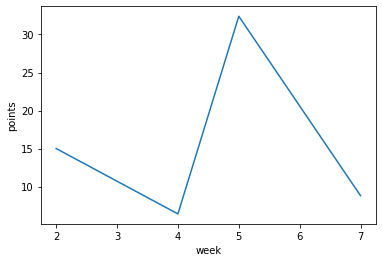

In [58]:
alt = wr[wr['Player Id'] == 'd.j.chark/2561018']
altered = alt[['week', 'points']]
altered = altered.set_index(['week'])
plt.xlabel('week')
plt.ylabel('points')
plt.plot(altered)

## Bootstrapping

In [135]:
qb[['Player Id', 'week', 'points']].groupby('week').describe()

points                                                          
      count       mean        std   min     25%    50%     75%    max
week                                                                 
1.0    15.0  16.501333   9.814967 -0.82  11.680  16.50  22.520  33.56
2.0    15.0  16.032000   8.574773  0.00  12.570  16.36  22.950  28.66
3.0    11.0  16.714545   7.217723  1.16  14.150  16.68  21.950  25.84
4.0    13.0   9.932308   7.871292  0.18   3.580   7.32  16.720  23.28
5.0    13.0  16.260000   9.561628  0.00   9.420  18.46  21.160  32.90
6.0    11.0  13.196364  11.140850  0.00   3.140  14.60  19.860  30.94
7.0    15.0  14.793333   9.253329 -0.20   7.440  17.52  21.370  29.18
8.0    10.0  13.870000   8.799239  0.32   8.655  13.84  19.925  28.18

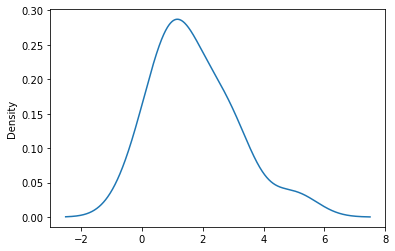

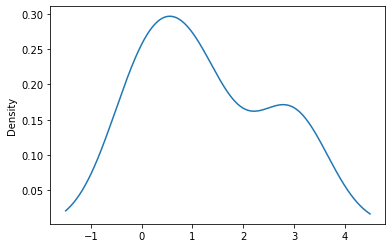

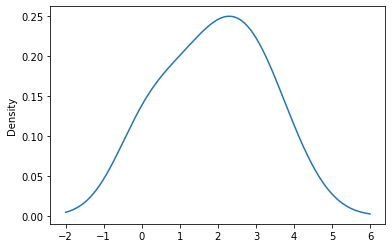

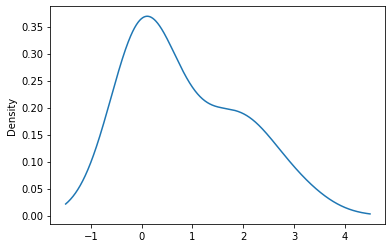

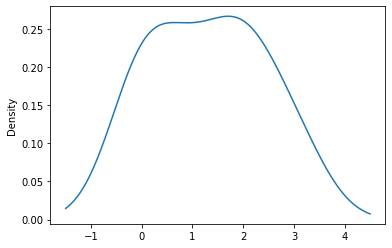

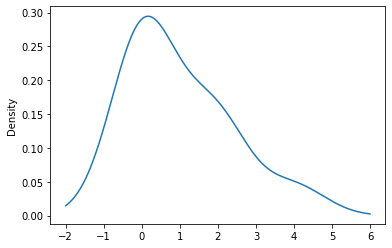

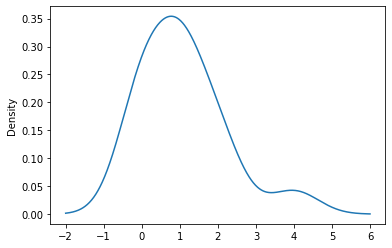

In [231]:
column = 'TD Passes'
week1 = qb[[column,'week']]
for i in range(1,8):
    plt.figure()
    week1[ week1['week']==i][column].plot.density()

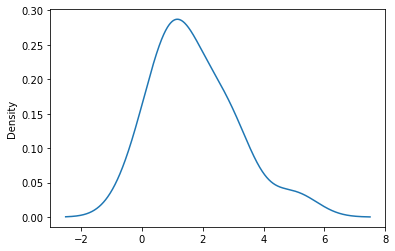

In [232]:
week1[week1['week']==1][column].plot.density()

In [204]:
list(qb[['Player Id', 'week', 'TD Passes', 'Sacks']].columns)

['Player Id', 'week', 'TD Passes', 'Sacks']

In [214]:
from scipy.stats import gamma
from scipy.stats import gaussian_kde 

In [241]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [250]:
def generate_distribution(df, var, week):
    """ Takes in a dataframe with important features for prediction, 
        and produces a distribution per week from each of the variables in it """

    # Get descriptive statistics
    mean = df[var][df['week'] == week].mean()
    std = df[var][df['week'] == week].std()
    low = df[var][df['week'] == week].min()
    high = df[var][df['week'] == week].max()
    
#     print(df[var][df['week'] == week].plot.density())
    
    # TEMPORARY: USE NORMAL DISTRIBUTION
    g = gaussian_kde(df[var][df['week'] == week])
    X = get_truncated_normal(mean=mean, sd=std, low=low, upp=high)
#     print([g(x)[0] for x in np.linspace(-2,8,10)])
    print(df[var][df['week'] == week])
    print(X.rvs(1))
    
    return X.rvs(1)
    

In [382]:
# How to take in account discrete values?!?!??!?!?!?!?!??!??!?!?
generate_distribution(qb, 'TD Passes', 1)

0     5.0
6     2.0
13    0.0
19    3.0
22    2.0
30    1.0
45    3.0
48    1.0
50    1.0
61    0.0
67    3.0
79    2.0
84    1.0
90    1.0
93    1.0
Name: TD Passes, dtype: float64
[2.13580652]


array([1.60302085])

### Important Variables for prediction!
- DEF: Ints, Fumbles, Fumbles Lost
- QB: TD Passes, Completion Percentage, Passer Rating
- RB: Rushing Attempts, Receptions, Yards Per Carry
- WR and TE: Yards per Reception, Yards Per Carry

In [602]:
class TimeSeriesRegressor(object):
    def __init__(self, df):
        # All features important for the position
        self.features = list(df.columns)
        self.features.remove('Player Id')
        self.features.remove('week')

        # All players in the dataframe
        df['Player Id'] = df['Player Id'].str.extract('(\d+)', expand=False).astype(int)
        self.players = list(df['Player Id'].unique())
    
    def generate_distribution(self, df, var, week):
        """ Takes in a dataframe with important features for prediction, 
            and produces a distribution per week from each of the variables in it """
        
        # Get descriptive statistics
        mean = df[var][df['week'] == week].mean()
        std = df[var][df['week'] == week].std()
        low = df[var][df['week'] == week].min()
        high = df[var][df['week'] == week].max()

    #     print(df[var][df['week'] == week].plot.density())

        # TEMPORARY: USE NORMAL DISTRIBUTION
        g = gaussian_kde(df[var][df['week'] == week])
        X = get_truncated_normal(mean=mean, sd=std, low=low, upp=high)
    #     print([g(x)[0] for x in np.linspace(-2,8,10)])
#         print(list(df[var][df['week'] == week]))
#         print(X.rvs(10))
    
        return X

    def complete_data(self, df):
        """ Takes in a dataframe with important features for prediction,
            and returns a dataframe with the same amount of players in every week, for all features"""
        
        # Make a copy of the df so we don't modify the original one
        new_df = df.copy()
        
        # Store PDFs of variables per week {week: (variable, pdf)}
        self.week_pdfs = {} 
        
        # For each week:
        for week in range(1, 9):
            # Get the players that don't appear in the week 
            cur_players = list(new_df['Player Id'][new_df['week'] == week].unique())
            missing_players = [player for player in self.players if player not in cur_players] 
            missing_values = {} # {player: {feature: value}}

            # For every missing player, add a new row for that week, that feature, sampling a value from the pdf
            for player in missing_players:
                missing_values[player] = {}
                
                for var in self.features:
                    # Create distribution from statistics for that week, and that feature
                    pdf = self.generate_distribution(new_df, var, week)
                
                    # Store value
                    missing_values[player][var] = pdf.rvs(1)[0]
            
            # Now add all the new missing values as rows to the old df
            missing_series = []
            for player, value_dict in missing_values.items():
                value_dict['Player Id'] = player
                value_dict['week'] = week
                missing_series.append(pd.Series(value_dict))

            new_df = new_df.append(pd.DataFrame(missing_series), ignore_index=True, sort=True)

        return new_df
    
    def _train_preprocess(self, df, feature):

        # Work with deep copy of df
        df2 = df.copy()

        # Zero step, strip player ID and week of strings so it's easier to deal with
        # df2['Player Id'] = df2['Player Id'].str.extract('(\d+)', expand=False).astype(int)
        df2['week'] = df2['week'].astype(int)

        # First, let's sort by week (and Player Id)!
        df2 = df2.sort_values(['week', 'Player Id'])

        # Then add extra features from the previous week (t-1)
        df2[f'Last_Week_{feature}'] = df2.groupby(['Player Id'])[feature].shift()
        
        # This would not be useful for a new instance, but maybe we can try for two weeks back?
        #df2['Last_Week_Diff'] = df2.groupby(['Player Id'])[f'Last_Week_{feature}'].diff()
        
        # Extra feature from second to last week
#         df2[f'Last-1_Week_{feature}'] = df2.groupby(['Player Id'])[feature].shift(2)

        # TODO Should we drop na or replace with 0s? 
        df2 = df2.dropna()

        return df2
    
    def _test_preprocessing(self, df, feature):
        df2 = df.copy()
        
        latest_week = df2['week'].max()
        
        # We need to add more rows for week 9, and the features from last week
        new_week = []

        for player in self.players:
            new_week.append(pd.Series({'Player Id': player, 'Passer Rating': 0, 'week': latest_week + 1}))
        
        df2 = df2.append(pd.DataFrame(new_week), ignore_index=True, sort=True)
        df2 = df2.sort_values(['week', 'Player Id'])
        
        # print(list(df2['Player Id']))
        #Strip player ID and week of strings so it's easier to deal with
        df2['week'] = df2['week'].astype(int)
        
        # Add the last week feature
        df2[f'Last_Week_{feature}'] = np.roll(df2[feature], len(self.players))
        df2 = df2.dropna()
        
        return df2
        

    def train(self, df, feature):
        """ Performs a time series regression in df[feature], produces num_tsteps predictions for the future """
        
        df2 = self._train_preprocess(df, feature)

        # Instantiate the models
        self.rfrg = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=69420)
        self.gbrg = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
        
        # Then, perform regression -> This is to see how it performs over weeks
        mean_error1 = []
        mean_error2 = []
        
        for week in range(4, 9):
            train = df2[df2['week'] < week]
            val = df2[df2['week'] == week]
            
            x_train, x_test = train.drop([feature], axis=1), val.drop([feature], axis=1)
            y_train, y_test = train[feature].values, val[feature].values
            
            self.rfrg.fit(x_train,y_train)
            self.gbrg.fit(x_train, np.log1p(y_train))
            
            preds1 = self.rfrg.predict(x_test)
            preds2 = np.expm1(self.gbrg.predict(x_test))
            
            error1 = rmsle(y_test, preds1)
            error2 = rmsle(y_test, preds2)
            
            print('Week %d - Error for Random Forest %.5f' % (week, error1))
            print('Week %d - Error for Gradient Boosting %.5f' % (week, error2))
            print()
            mean_error1.append(error1)
            mean_error2.append(error2)
        
        print()
        print("Feature statistics:")
        print(f"Min value for feature {feature}: {df[feature].min()}")
        print(f"Max value for feature {feature}: {df[feature].max()}")
        print(f"Mean value for feature {feature}: {df[feature].mean()}")
        print(f"Standard deviation for feature {feature}: {df[feature].std()}")
        print()
        
        print("Results")
        print('Mean Error for Random Forest = %.5f' % np.mean(mean_error1))
        print('Mean Error for Gradient Boosting = %.5f' % np.mean(mean_error2))
        
        # Note: the final model is trained on every week and stored in self.model!
        final_xtrain = df2.drop([feature], axis=1)
        final_ytrain = df2[feature].values
        
        self.rfrg.fit(final_xtrain, final_ytrain)
        self.gbrg.fit(final_xtrain, np.log1p(final_ytrain))
            
    def predict(self, df, feature, model="rfrg"):
        """ """
        
        # Preprocessing necessary!
        df2 = self._test_preprocessing(df, feature)
        
        # Remove current feature for predictions
        df3 = df2.drop(feature, axis=1)
        
        # Remove previous weeks
        df3 = df3.drop(list(range(0, len(df3)-len(self.players))))
        
        # Make predictions
        if model == "rfrg":
            preds = self.rfrg.predict(df3)
        elif model == "gbrg":
            preds = self.gbrg.predict(df3)
        
        # Store predictions
        final_df = self.store_predictions(preds, df2, feature)
        
        return preds, final_df
    
    def store_predictions(self, preds, df, feature):
        """ Stores prediction from model as rows to the dataframe """
        
        prev_values = list(df[feature].iloc[:len(df)-len(self.players)])
        prev_values.extend(preds)
        
        df[feature] = prev_values
        
        return df

In [617]:
qb_train = qb[['Player Id', 'week', 'Passer Rating']]
ts_reg = TimeSeriesRegressor(qb_train)
new_qb = ts_reg.complete_data(qb_train)
ts_reg.train(new_qb, 'Passer Rating')

/Users/dafirebanks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Week 4 - Error for Random Forest 36.91134
Week 4 - Error for Gradient Boosting 36.86751

Week 5 - Error for Random Forest 27.08128
Week 5 - Error for Gradient Boosting 26.78363

Week 6 - Error for Random Forest 45.57102
Week 6 - Error for Gradient Boosting 43.44934

Week 7 - Error for Random Forest 40.98799
Week 7 - Error for Gradient Boosting 41.22217

Week 8 - Error for Random Forest 32.17348
Week 8 - Error for Gradient Boosting 45.44345


Feature statistics:
Min value for feature Passer Rating: 0.0
Max value for feature Passer Rating: 158.3
Mean value for feature Passer Rating: 87.16363235746155
Standard deviation for feature Passer Rating: 31.783717545080197

Results
Mean Error for Random Forest = 36.54502
Mean Error for Gradient Boosting = 38.75322


In [618]:
preds, new_df = ts_reg.predict(new_qb, "Passer Rating")

In [619]:
new_df

,Passer Rating,Player Id,week,Last_Week_Passer Rating
6,85.800000,310.0,1,0.000000
50,105.300000,382.0,1,0.000000
19,110.000000,79860.0,1,0.000000
112,19.008729,81284.0,1,0.000000
22,106.500000,2495143.0,1,0.000000
121,79.886491,2495240.0,1,0.000000
130,75.063091,2504211.0,1,0.000000
125,68.128829,2505076.0,1,0.000000
116,141.349482,2505982.0,1,0.000000
30,95.500000,2505996.0,1,0.000000


In [620]:
lol, new_df = ts_reg.predict(new_df, "Passer Rating")

In [621]:
new_df

,Last_Week_Passer Rating,Passer Rating,Player Id,week
0,0.000000,85.800000,310.0,1
1,0.000000,105.300000,382.0,1
2,0.000000,110.000000,79860.0,1
3,0.000000,19.008729,81284.0,1
4,0.000000,106.500000,2495143.0,1
5,0.000000,79.886491,2495240.0,1
6,0.000000,75.063091,2504211.0,1
7,0.000000,68.128829,2505076.0,1
8,0.000000,141.349482,2505982.0,1
9,0.000000,95.500000,2505996.0,1
